**Synthetic Data Generation Using Bayesian Method Based on Distribution**

**1. Import Dataset**

In [1]:
#Download dataset from: https://drive.google.com/file/d/11eUj_VLqcbMjEAN75-kcbwFN5-zu0Az8/view?usp=sharing

!gdown 11eUj_VLqcbMjEAN75-kcbwFN5-zu0Az8

Downloading...
From: https://drive.google.com/uc?id=11eUj_VLqcbMjEAN75-kcbwFN5-zu0Az8
To: /content/database2.txt
100% 1.90M/1.90M [00:00<00:00, 248MB/s]


In [2]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 11.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az
# pd.options.display.float_format = '{:.2f}'.format
import scipy
import tslearn
from tslearn import utils

import matplotlib.pyplot  as plt
import seaborn as sns
sns.set()

import scipy.io
import scipy.optimize

from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal
import matplotlib.cm as cm
from matplotlib.lines import Line2D

Read dataset

In [5]:
with open('database2.txt', 'r') as f:
    data = []
    for line in f:
        # split line into values using space as the delimiter
        values = line.strip().split(' ')
        values = [float(value) if value else np.nan for value in values]
        data.append(values)


In [6]:
series_list = []

for i in range(len(data)):
    series = [x for x in data[i] if x is not None]
    series_list.append(series)

In [7]:
X = []
y = []

for series in series_list:
    X.append(series[:-1])
    y.append(series[-1])

raw_data = np.array(X, dtype=object)
raw_class = np.array(y)

In [ ]:
print(raw_data.shape, raw_class.shape)

(377,) (377,)


Series data and label have same row 377

In [8]:
print(len(series_list))
print(f'Class 1 : {sum(1 if series[-1] == 1 else 0 for series in series_list)}, Class 2 : {sum(1 if series[-1] == 2 else 0 for series in series_list)}, Class 3 : {sum(1 if series[-1] == 3 else 0 for series in series_list)}, Class 4 : {sum(1 if series[-1] == 4 else 0 for series in series_list)}, Class 5 : {sum(1 if series[-1] == 5 else 0 for series in series_list)}')

377
Class 1 : 95, Class 2 : 73, Class 3 : 96, Class 4 : 89, Class 5 : 24


we get 5 class from dataset with number of series data inside of it

now we grouping series based on its label

In [9]:
series_class_1 = []
series_class_2 = []
series_class_3 = []
series_class_4 = []
series_class_5 = []

for series in series_list:
    if series[-1] == 1:
        series_class_1.append(series[:-1])
    elif series[-1] == 2:
        series_class_2.append(series[:-1])
    elif series[-1] == 3:
        series_class_3.append(series[:-1])
    elif series[-1] == 4:
        series_class_4.append(series[:-1])
    elif series[-1] == 5:
        series_class_5.append(series[:-1])

plot series from each label

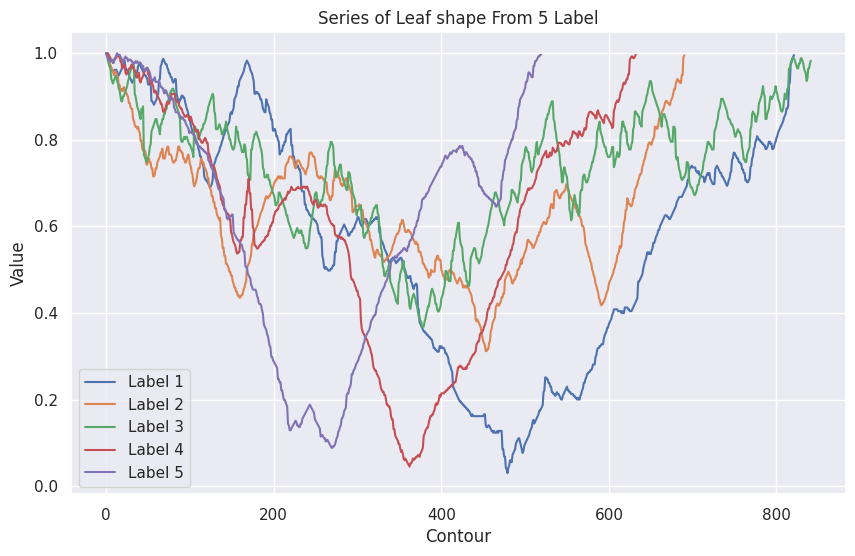

In [10]:
dft1 = series_class_1
dft2 = series_class_2
dft3 = series_class_3
dft4 = series_class_4
dft5 = series_class_5

plt.figure(figsize=(10, 6))
plt.plot(dft1[0], label='Label 1')
plt.plot(dft2[0], label='Label 2')
plt.plot(dft3[0], label='Label 3')
plt.plot(dft4[0], label='Label 4')
plt.plot(dft5[0], label='Label 5')
plt.title('Series of Leaf shape From 5 Label')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)
plt.show()


show data distribution using gaussian inference

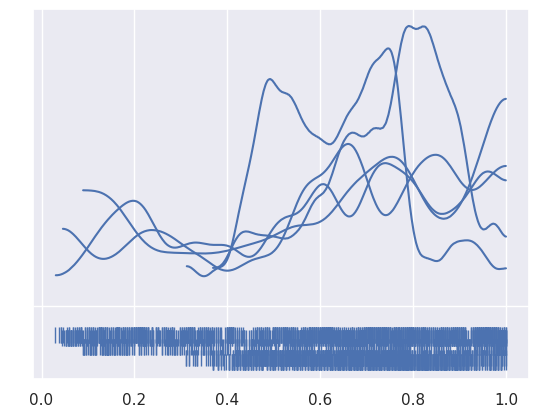

In [ ]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

az.plot_kde(np.array(dft1[0]), rug=True)
az.plot_kde(np.array(dft2[0]), rug=True)
az.plot_kde(np.array(dft3[0]), rug=True)
az.plot_kde(np.array(dft4[0]), rug=True)
az.plot_kde(np.array(dft5[0]), rug=True)
plt.yticks([0], alpha=0)
plt.show()


Draw orginal pseudo time series from label 1-5

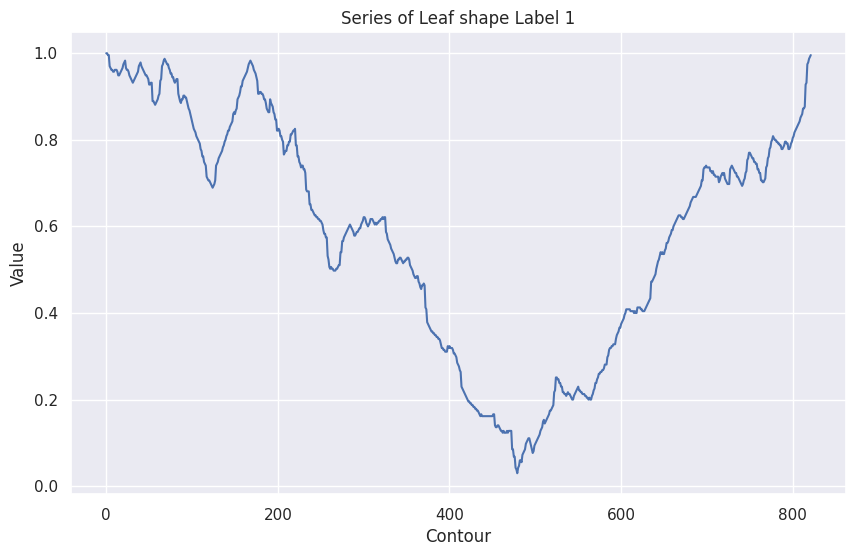

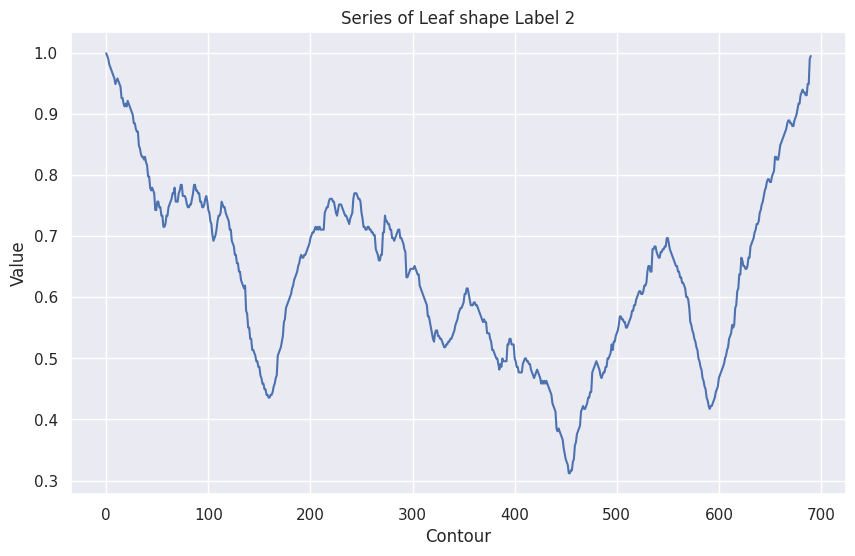

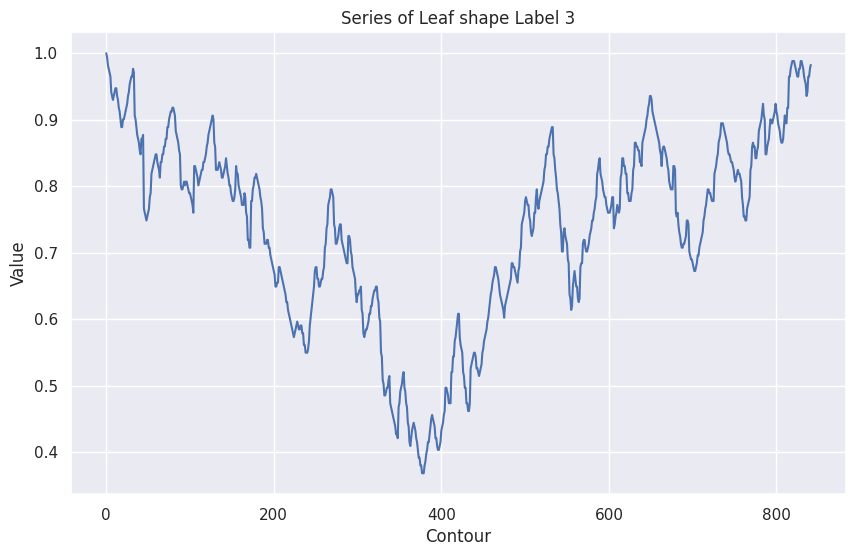

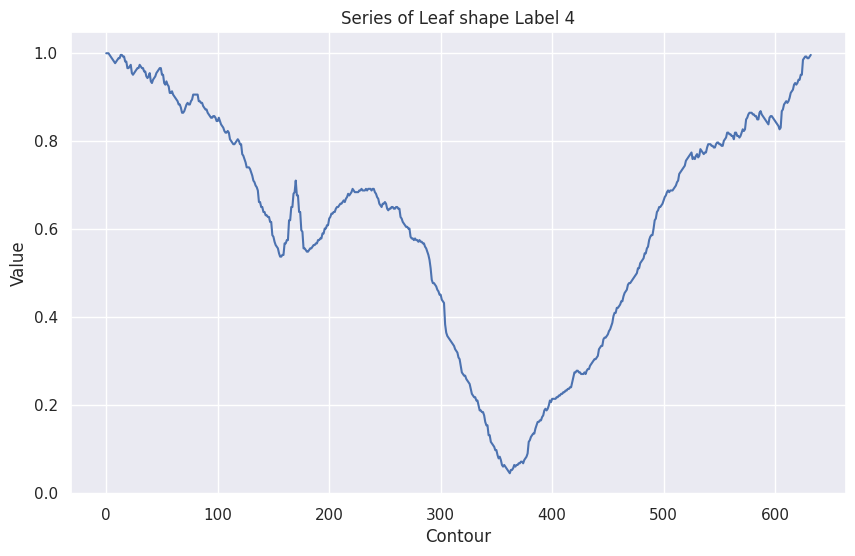

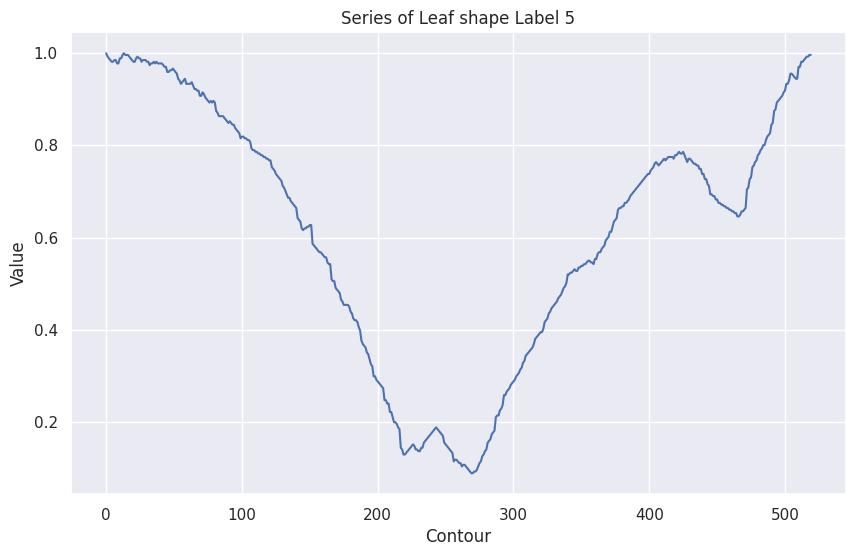

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dft1[0])
plt.title('Series of Leaf shape Label 1')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dft2[0])
plt.title('Series of Leaf shape Label 2')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dft3[0])
plt.title('Series of Leaf shape Label 3')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dft4[0])
plt.title('Series of Leaf shape Label 4')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dft5[0])
plt.title('Series of Leaf shape Label 5')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

We have done to separate series data for every label, now we resample these series in every label since they have unequal size

The dataset is time series data comes from leaf shape and have different size of series, when read dataset as Data Frame it shows blank space that is not represent the leaf shape filling as NaN or missing value automatically by Pandas Data Frame. 

We can't handle this different sizes with any handling missing values method, since it will change the shape of leaf and data distribution around it. 

Thus, we propose resample approach for unequal time series data using library from tslearn

**Resample for unequal pseudo time series data**

**Label 1**

In [11]:
from tslearn.utils import to_time_series_dataset
X1 = to_time_series_dataset(series_class_1)
# X1

from tslearn.preprocessing import TimeSeriesResampler
resampled_X1 = TimeSeriesResampler(sz=X1.shape[1]).fit_transform(X1)
resampled_X1.shape

(95, 988, 1)

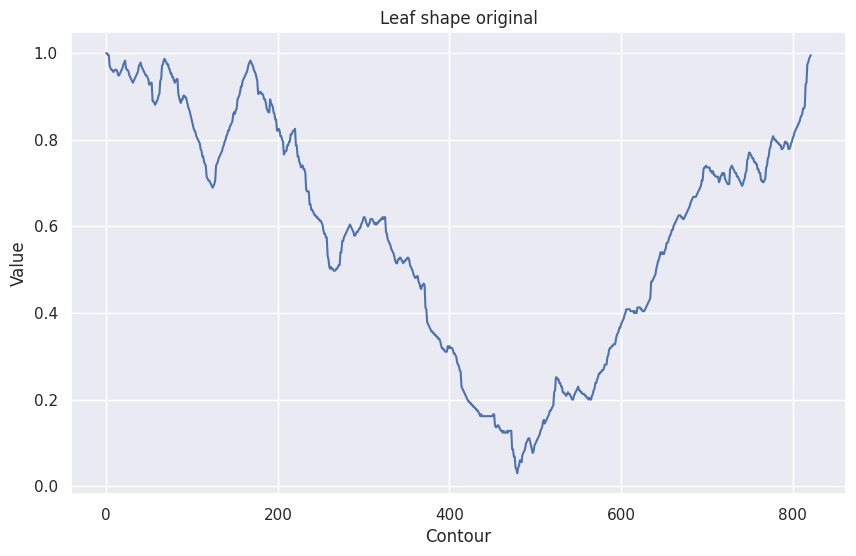

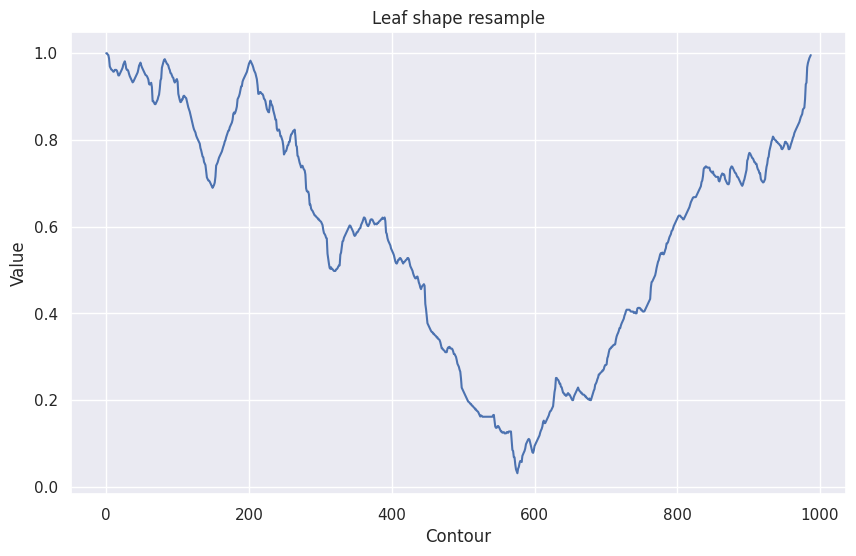

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dft1[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(resampled_X1[0])
plt.title('Leaf shape resample')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 2**

In [12]:
from tslearn.utils import to_time_series_dataset
X2 = to_time_series_dataset(series_class_2)

from tslearn.preprocessing import TimeSeriesResampler
resampled_X2 = TimeSeriesResampler(sz=X2.shape[1]).fit_transform(X2)
resampled_X2.shape

(73, 790, 1)

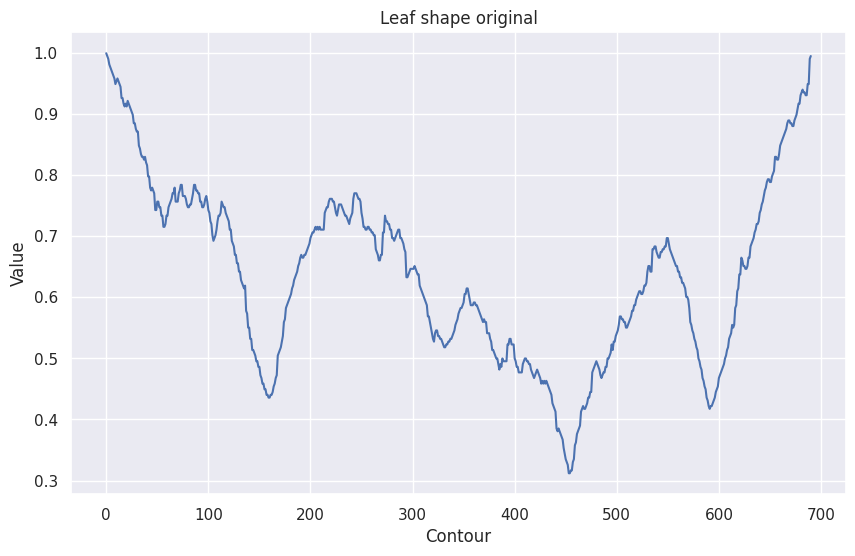

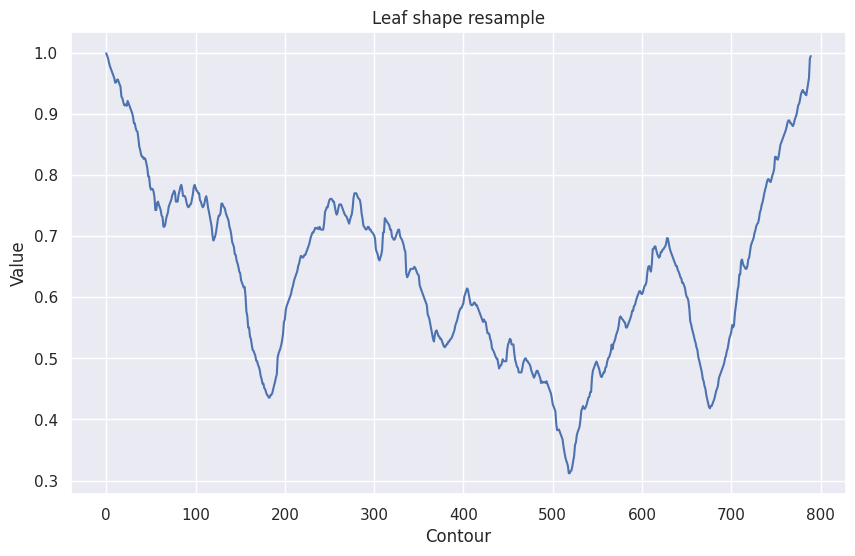

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dft2[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(resampled_X2[0])
plt.title('Leaf shape resample')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 3**

In [13]:
from tslearn.utils import to_time_series_dataset
X3 = to_time_series_dataset(series_class_3)

from tslearn.preprocessing import TimeSeriesResampler
resampled_X3 = TimeSeriesResampler(sz=X3.shape[1]).fit_transform(X3)
resampled_X3.shape

(96, 1086, 1)

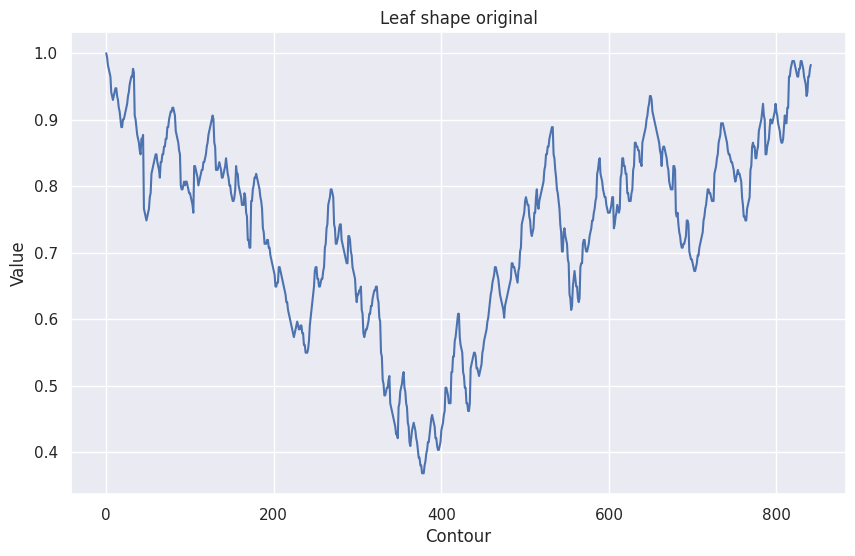

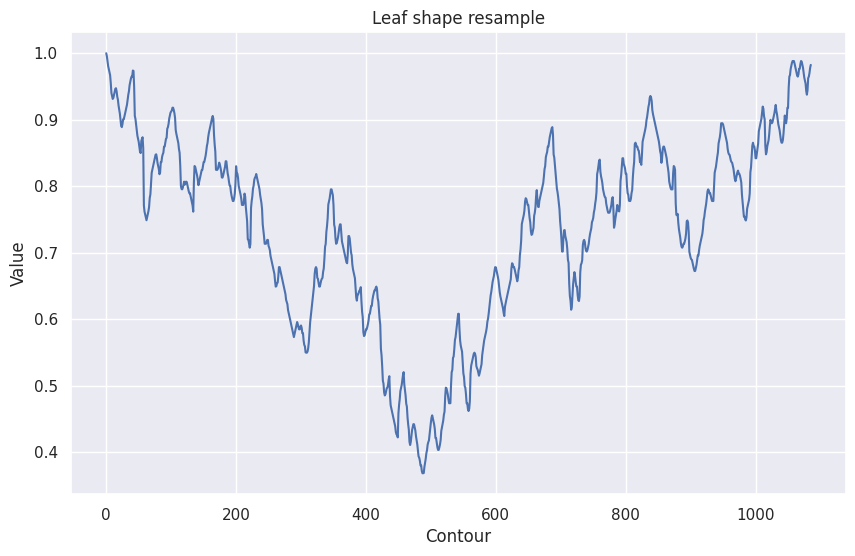

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dft3[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(resampled_X3[0])
plt.title('Leaf shape resample')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 4**

In [14]:
from tslearn.utils import to_time_series_dataset
X4 = to_time_series_dataset(series_class_4)

from tslearn.preprocessing import TimeSeriesResampler
resampled_X4 = TimeSeriesResampler(sz=X4.shape[1]).fit_transform(X4)
resampled_X4.shape

(89, 1063, 1)

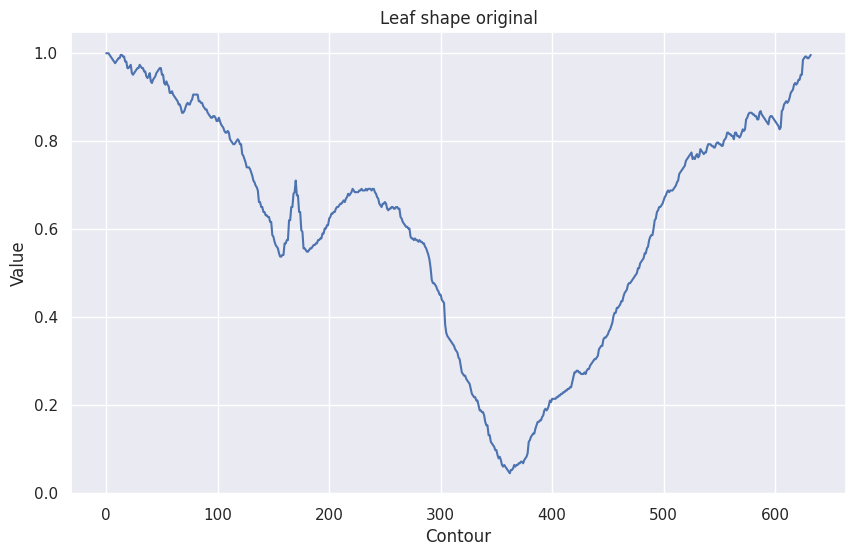

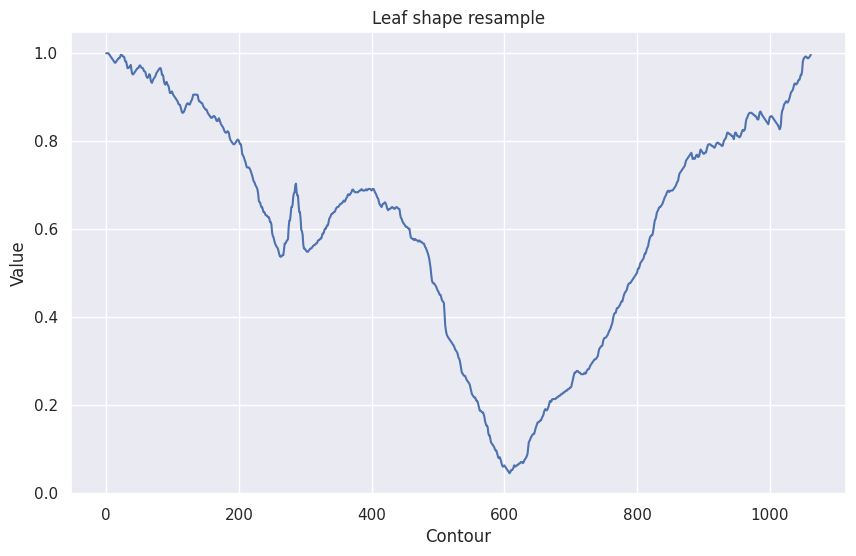

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dft4[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(resampled_X4[0])
plt.title('Leaf shape resample')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 5**

In [15]:
from tslearn.utils import to_time_series_dataset
X5 = to_time_series_dataset(series_class_5)

from tslearn.preprocessing import TimeSeriesResampler
resampled_X5 = TimeSeriesResampler(sz=X5.shape[1]).fit_transform(X5)
resampled_X5.shape

(24, 731, 1)

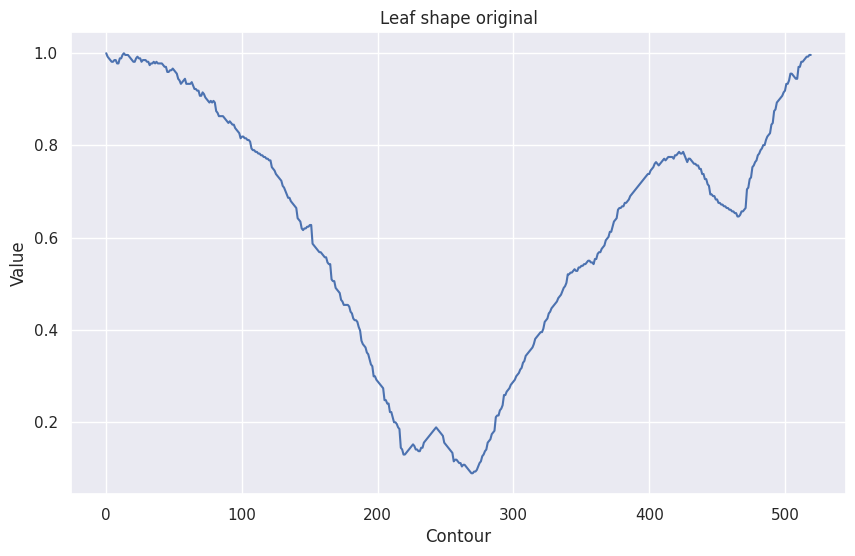

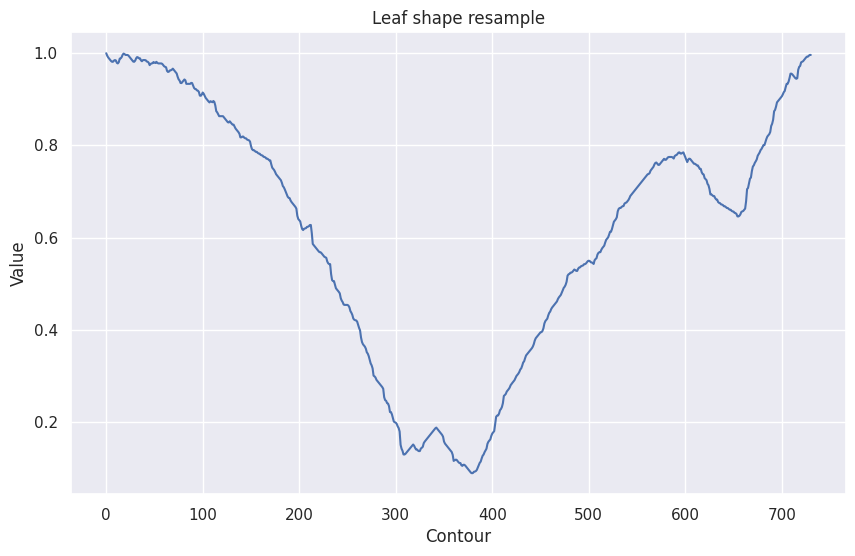

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dft5[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(resampled_X5[0])
plt.title('Leaf shape resample')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

Image shows there is no change after we perform resampling technique, now draw the shape of leaf from each label to have better view about the dataset

We have done to resample unequal pseudo time series data for each label

Column represent the length of contour for every leaf shape series. And row represent number of pseudo time series data

show data distribution of leaf shape

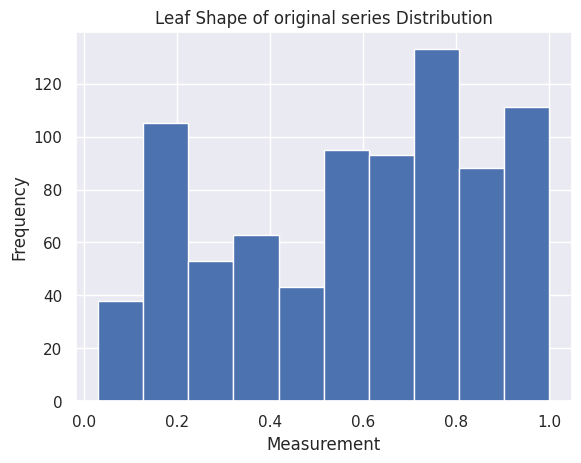

In [ ]:
plt.hist(dft1[0])
plt.title('Leaf Shape of original series Distribution')
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

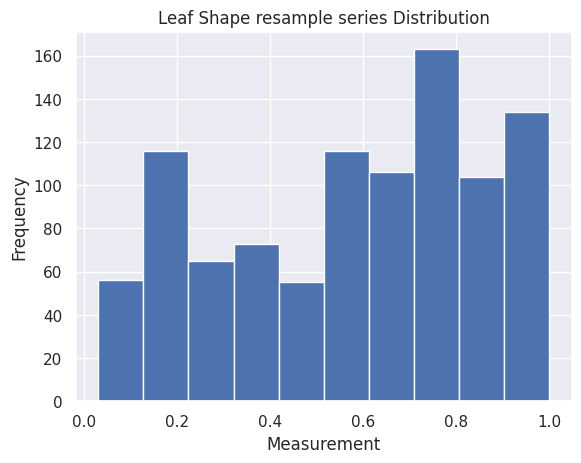

In [ ]:
plt.hist(resampled_X1[0])
plt.title('Leaf Shape resample series Distribution')
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

Show data distribution with gaussian inference

([<matplotlib.axis.YTick at 0x7fec85b7ceb0>], [Text(0, 0, '0')])

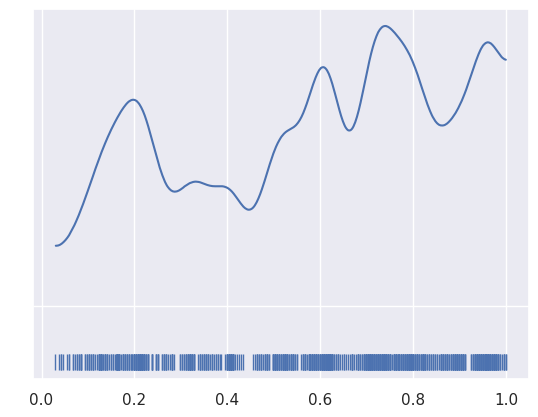

In [ ]:
%matplotlib inline

az.plot_kde(np.array(dft1[0]), rug=True)
plt.yticks([0], alpha=0)

([<matplotlib.axis.YTick at 0x7fec859d2dd0>], [Text(0, 0, '0')])

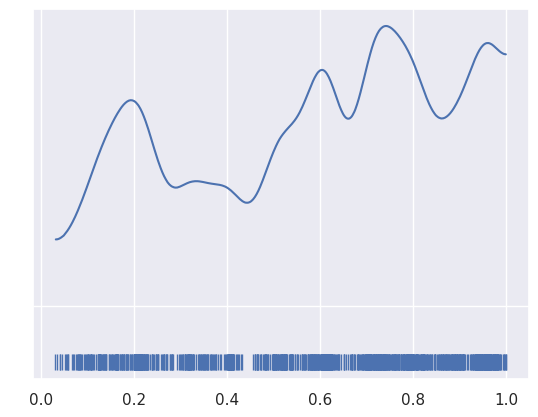

In [ ]:
%matplotlib inline

az.plot_kde(resampled_X1[0], rug=True)
plt.yticks([0], alpha=0)

## Model

We will perform Gaussian inferences on the leaf shape time series data. Here's some of the modelling choices that go into this.

Choices for leaf shape likelihood function:

The leaf shape data is modelled as a linear combination of the independent variables. We assume that the leaf shape time series data is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.

That is how we proceed below:

**Label 1**

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

y = resampled_X1[0].flatten()
X = np.linspace(0, len(y), len(y)).reshape(-1, 1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

In [35]:
# Generate synthetic data
X_synthetic = np.linspace(0, len(y), 2*len(y)).reshape(-1, 1) 
y_synthetic_mean, y_synthetic_std = gp.predict(X_synthetic, return_std=True)
y_synthetic = np.random.normal(y_synthetic_mean, y_synthetic_std)


In [37]:
# Generate 100 synthetic data
synthetic_data = []

for _ in range(100):
        # Generate synthetic data
        X_synthetic = np.linspace(0, len(y), len(y)).reshape(-1, 1)  # new time points
        y_synthetic_mean, y_synthetic_std = gp.predict(X_synthetic, return_std=True)
        y_synthetic = np.random.normal(y_synthetic_mean, y_synthetic_std)
        synthetic_data.append(y_synthetic)

synthetic_data = np.array(synthetic_data)

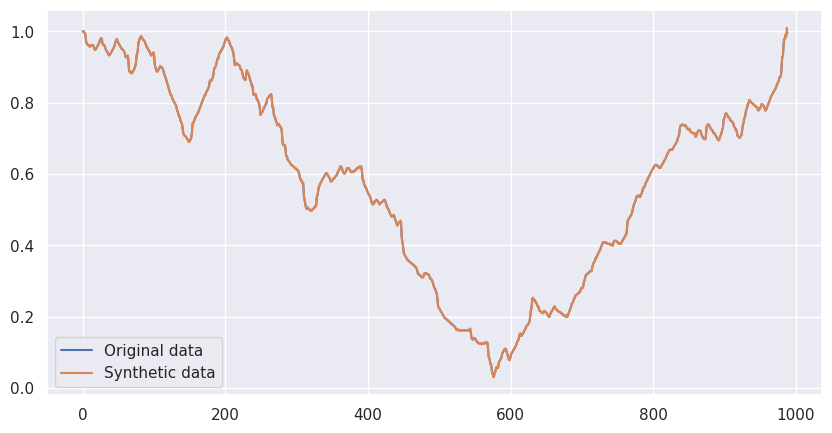

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(X, y, label='Original data')
plt.plot(X_synthetic, y_synthetic, label='Synthetic data')
plt.fill_between(X_synthetic.ravel(), y_synthetic_mean - y_synthetic_std, y_synthetic_mean + y_synthetic_std, alpha=0.2)
plt.legend()
plt.show()

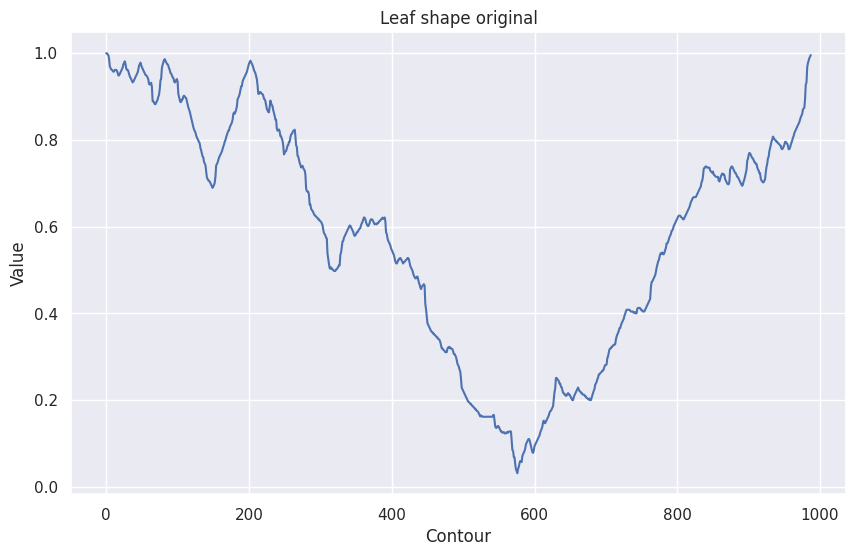

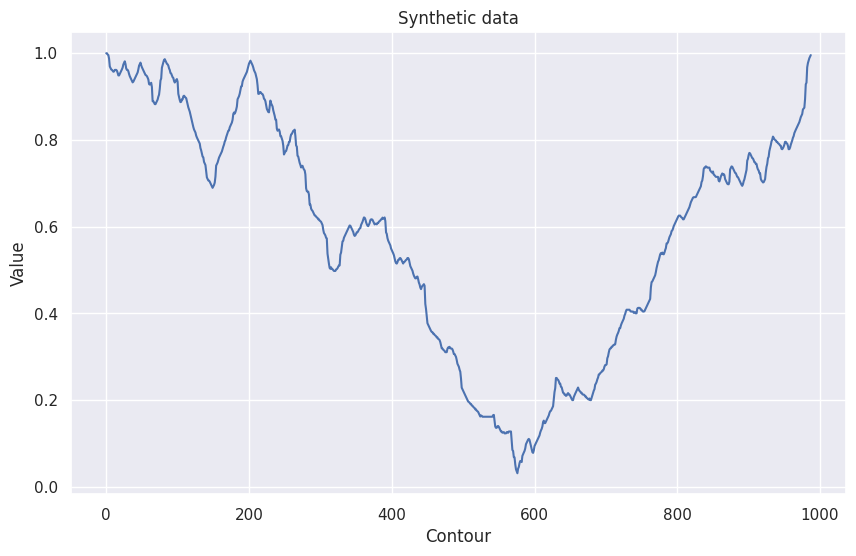

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(resampled_X1[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(synthetic_data[0])
plt.title('Synthetic data')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

Figure above shows that synthetic data have same shape with original data, thus guarantee that the model is good.

We instantiate the Models in SKlearn like above.

model called Gaussian process regression (GPR) which use Bayesian probabilistic from SKlearn was used

This model allows prediction without prior fitting (based on the GP prior)

provides an additional method sample_y(X), which evaluates samples drawn from the GPR (prior or posterior) at given inputs

exposes a method log_marginal_likelihood(theta), which can be used externally for other ways of selecting hyperparameters, e.g., via Markov chain Monte Carlo.



**Label 2**

In [54]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

y2 = resampled_X2[0].flatten()
X2 = np.linspace(0, len(y2), len(y2)).reshape(-1, 1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp2.fit(X2, y2)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

In [56]:
# Generate synthetic data
X_synthetic2 = np.linspace(0, len(y2), 2*len(y2)).reshape(-1, 1)
y_synthetic_mean2, y_synthetic_std2 = gp2.predict(X_synthetic2, return_std=True)
y_synthetic2 = np.random.normal(y_synthetic_mean2, y_synthetic_std2)

In [57]:
synthetic_data2 = []
for _ in range(100):
        # Generate synthetic data
        X_synthetic2 = np.linspace(0, len(y2), len(y2)).reshape(-1, 1)
        y_synthetic_mean2, y_synthetic_std2 = gp2.predict(X_synthetic2, return_std=True)
        y_synthetic2 = np.random.normal(y_synthetic_mean2, y_synthetic_std2)
        synthetic_data2.append(y_synthetic2)

# Convert list of synthetic series to numpy array
synthetic_data2 = np.array(synthetic_data2)

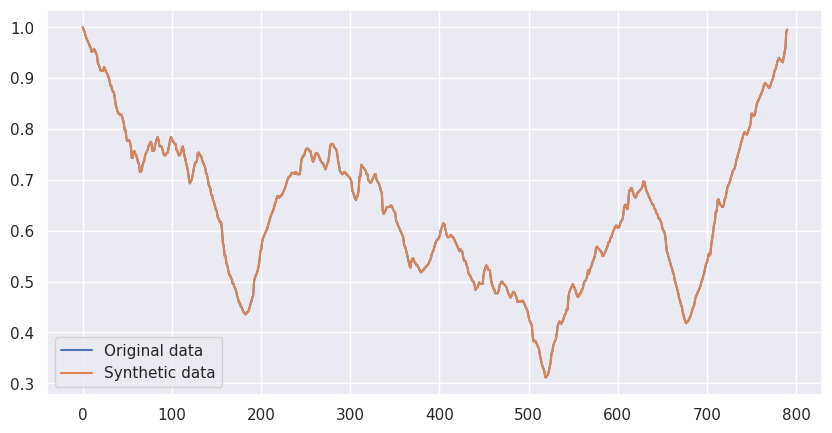

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(X2, y2, label='Original data')
plt.plot(X_synthetic2, y_synthetic2, label='Synthetic data')
# plt.fill_between(X_synthetic.ravel(), y_synthetic_mean - y_synthetic_std, y_synthetic_mean + y_synthetic_std, alpha=0.2)
plt.legend()
plt.show()

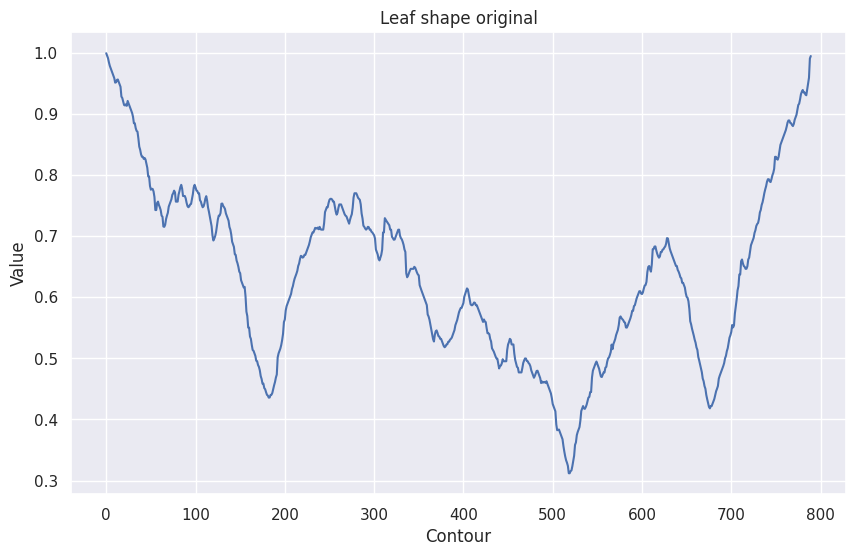

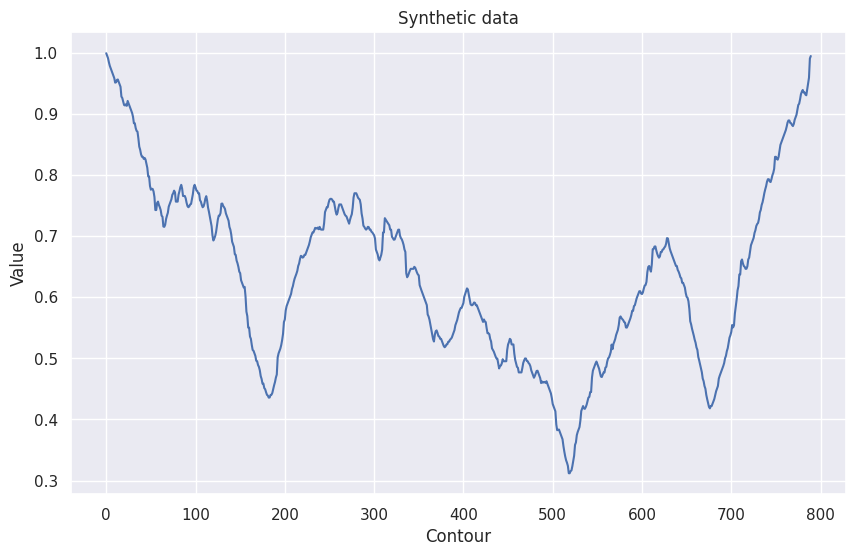

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(resampled_X2[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(synthetic_data2[0])
plt.title('Synthetic data')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 3**

In [59]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

y3 = resampled_X3[0].flatten()
X3 = np.linspace(0, len(y3), len(y3)).reshape(-1, 1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp3.fit(X3, y3)

synthetic_data3 = []
for _ in range(100):
        # Generate synthetic data
        X_synthetic3 = np.linspace(0, len(y3), len(y3)).reshape(-1, 1) 
        y_synthetic_mean3, y_synthetic_std3 = gp3.predict(X_synthetic3, return_std=True)
        y_synthetic3 = np.random.normal(y_synthetic_mean3, y_synthetic_std3)
        synthetic_data3.append(y_synthetic3)

# Convert list of synthetic series to numpy array
synthetic_data3 = np.array(synthetic_data3)

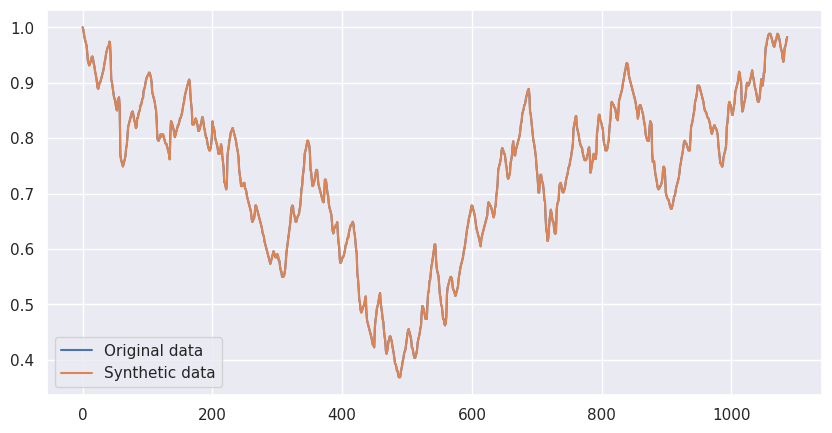

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(X3, y3, label='Original data')
plt.plot(X_synthetic3, y_synthetic3, label='Synthetic data')
plt.fill_between(X_synthetic3.ravel(), y_synthetic_mean3 - y_synthetic_std3, y_synthetic_mean3 + y_synthetic_std3, alpha=0.2)
plt.legend()
plt.show()

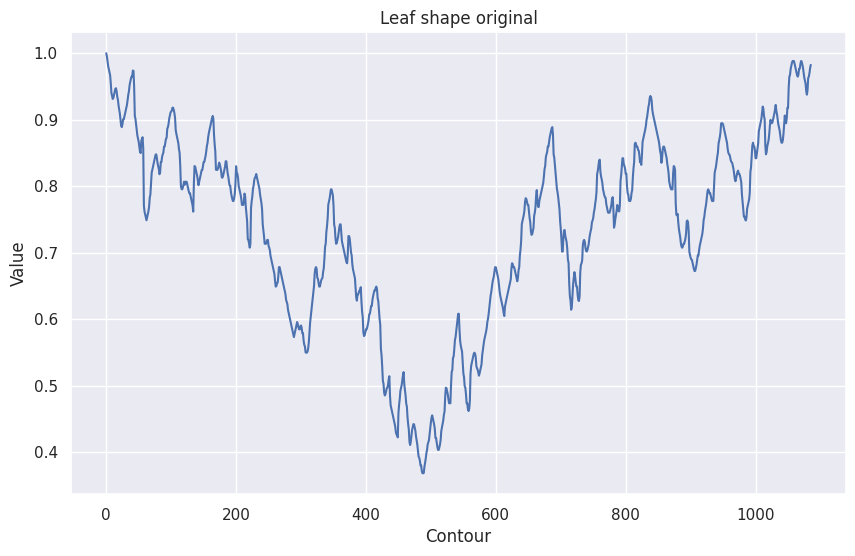

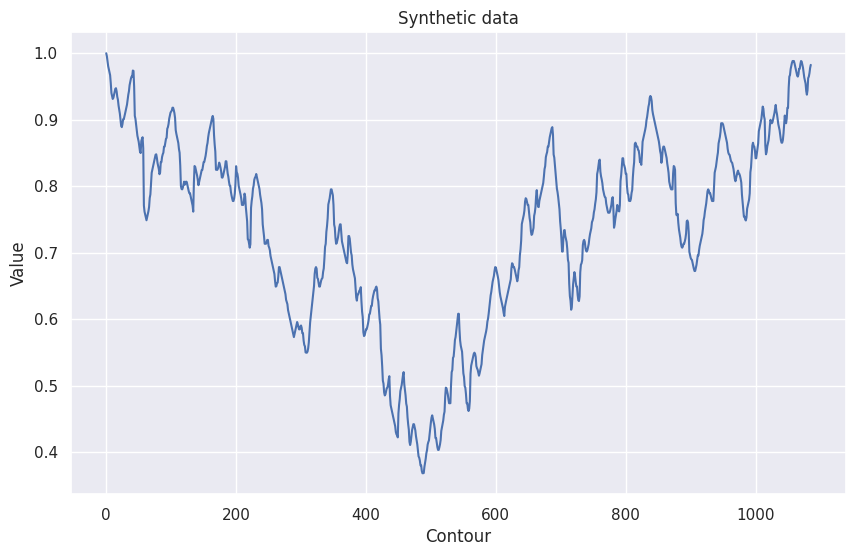

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(resampled_X3[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(synthetic_data3[0])
plt.title('Synthetic data')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 4**

In [61]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

y4 = resampled_X4[0].flatten()
X4 = np.linspace(0, len(y4), len(y4)).reshape(-1, 1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp4 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp4.fit(X4, y4)

synthetic_data4 = []
for _ in range(100):
        # Generate synthetic data
        X_synthetic4 = np.linspace(0, len(y4), len(y4)).reshape(-1, 1)  # new time points
        y_synthetic_mean4, y_synthetic_std4 = gp4.predict(X_synthetic4, return_std=True)
        y_synthetic4 = np.random.normal(y_synthetic_mean4, y_synthetic_std4)
        synthetic_data4.append(y_synthetic4)

# Convert list of synthetic series to numpy array
synthetic_data4 = np.array(synthetic_data4)

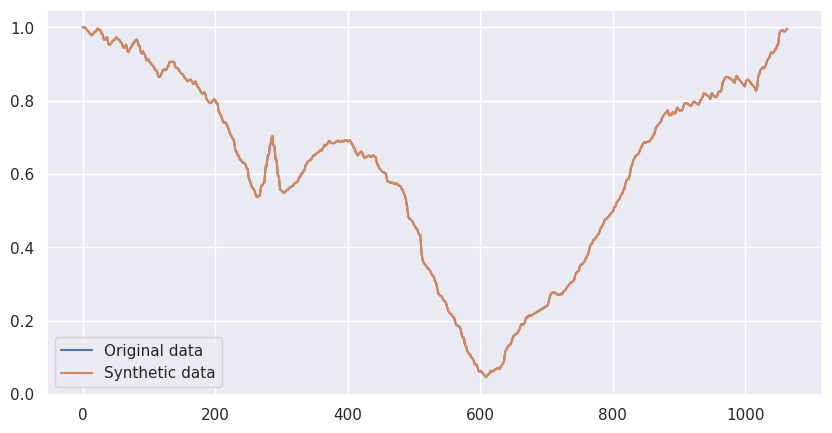

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(X4, y4, label='Original data')
plt.plot(X_synthetic4, y_synthetic4, label='Synthetic data')
plt.fill_between(X_synthetic4.ravel(), y_synthetic_mean4 - y_synthetic_std4, y_synthetic_mean4 + y_synthetic_std4, alpha=0.2)
plt.legend()
plt.show()

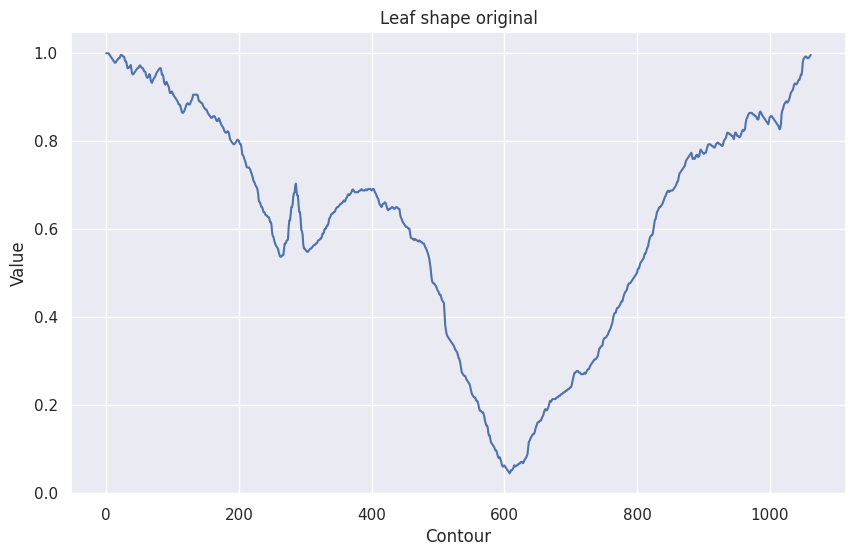

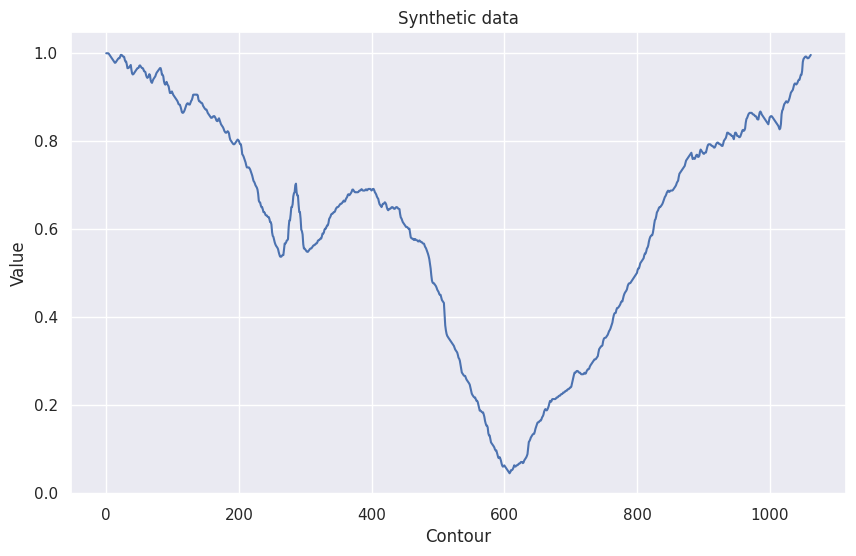

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(resampled_X4[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(synthetic_data4[0])
plt.title('Synthetic data')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

**Label 5**

In [63]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

y5 = resampled_X5[0].flatten()
X5 = np.linspace(0, len(y5), len(y5)).reshape(-1, 1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp5 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp5.fit(X5, y5)

synthetic_data5 = []
for _ in range(100):
        # Generate synthetic data
        X_synthetic5 = np.linspace(0, len(y5), len(y5)).reshape(-1, 1)  # new time points
        y_synthetic_mean5, y_synthetic_std5 = gp5.predict(X_synthetic5, return_std=True)
        y_synthetic5 = np.random.normal(y_synthetic_mean5, y_synthetic_std5)
        synthetic_data5.append(y_synthetic5)

# Convert list of synthetic series to numpy array
synthetic_data5 = np.array(synthetic_data5)

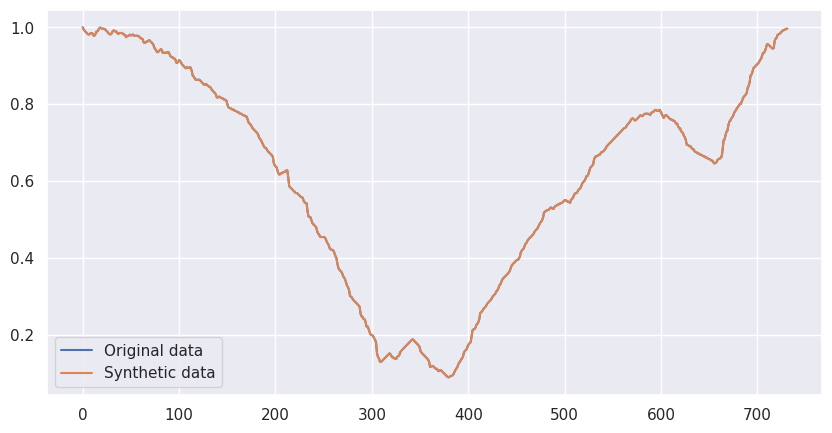

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(X5, y5, label='Original data')
plt.plot(X_synthetic5, y_synthetic5, label='Synthetic data')
plt.fill_between(X_synthetic5.ravel(), y_synthetic_mean5 - y_synthetic_std5, y_synthetic_mean5 + y_synthetic_std5, alpha=0.2)
plt.legend()
plt.show()

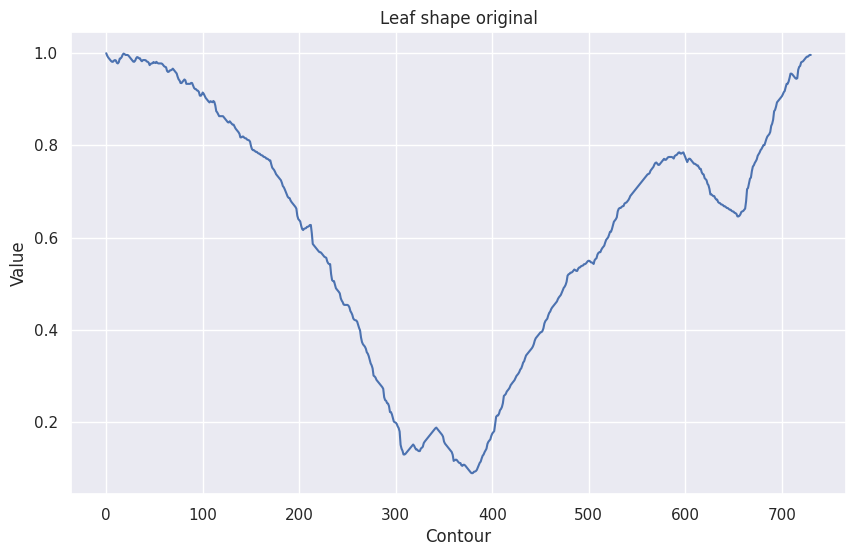

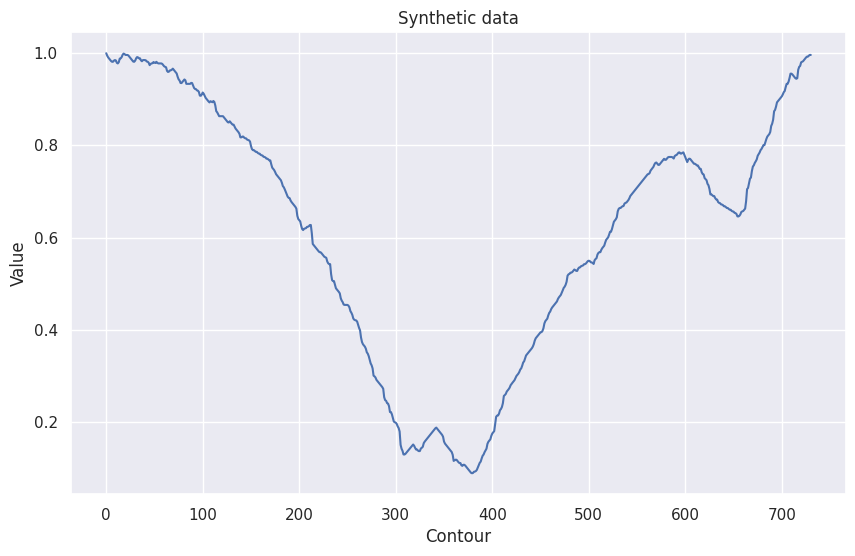

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(resampled_X5[0])
plt.title('Leaf shape original')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(synthetic_data5[0])
plt.title('Synthetic data')
plt.xlabel('Contour')
plt.ylabel('Value')
plt.show()

## Evaluate Model

Label 1

In [42]:
from scipy import stats

ks_stat, p_value = stats.ks_2samp(y, y_synthetic)

print(f"KS statistic: {ks_stat}")
print(f"P-value: {p_value}")


KS statistic: 0.009109311740890687
P-value: 0.999999999999098


It can be seen the evaluation result using Kolmogorov-Smirnov (KS) test shows good result. A small Kolmogorov-Smirnov (KS) statistic and a high p-value generally suggest that the synthetic data and the original data come from the same distribution, under the assumption of the KS test.

The KS statistic measures the maximum difference between the cumulative distribution functions (CDFs) of the two datasets being compared. Therefore, a small KS statistic 0.009109311740890687 indicates a small difference between the CDFs of the synthetic data and original data.

The p-value 0.999999999999098 is used to make a decision about the null hypothesis. The null hypothesis of the KS test is that the two datasets come from the same distribution. A high p-value means we fail to reject the null hypothesis, thus it's likely that the synthetic data and original data come from the same distribution.

Label 2

In [65]:
from scipy import stats

ks_stat2, p_value2 = stats.ks_2samp(y2, y_synthetic2)

print(f"KS statistic: {ks_stat2}")
print(f"P-value: {p_value2}")


KS statistic: 0.006329113924050633
P-value: 1.0


Label 3

In [66]:
from scipy import stats

ks_stat3, p_value3 = stats.ks_2samp(y3, y_synthetic3)

print(f"KS statistic: {ks_stat3}")
print(f"P-value: {p_value3}")


KS statistic: 0.004604051565377533
P-value: 0.9999999999999998


Label 4

In [69]:
from scipy import stats

ks_stat4, p_value4 = stats.ks_2samp(y4, y_synthetic4)

print(f"KS statistic: {ks_stat4}")
print(f"P-value: {p_value4}")

KS statistic: 0.005644402634054563
P-value: 1.0


<ipython-input-69-ca7b7767904c>:3: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_stat4, p_value4 = stats.ks_2samp(y4, y_synthetic4)


Label 5

In [68]:
from scipy import stats

ks_stat5, p_value5 = stats.ks_2samp(y5, y_synthetic5)

print(f"KS statistic: {ks_stat5}")
print(f"P-value: {p_value5}")


KS statistic: 0.005471956224350205
P-value: 1.0


<ipython-input-68-3fd2adb46936>:3: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_stat5, p_value5 = stats.ks_2samp(y5, y_synthetic5)


From the evaluation of all label in the dataset, it shows that synthetic data from label 5 is the best synthetic data. It shows result 
KS statistic: 0.005471956224350205
P-value: 1.0

A small Kolmogorov-Smirnov (KS) statistic and a high p-value generally suggest that the synthetic data and the original data come from the same distribution, under the assumption of the KS test.

Both, a small KS statistic 0.005471956224350205 and p-value 1.0 KS test shows that the two datasets come from the same distribution. 

## Extract features for Data Augmentation

Pseudo time series data offers a wide range of features that can be extracted for further analysis, predictive modeling, or other purposes. For this experiment, we will extract statistical features from synthetic data values and include measures such as **mean, median, standard deviation, variance**. This features can often provide useful summaries of the overall characteristics of a time series. All this features will save in data frame and in the end of data frame column, label will assign as class of the data point.

Label 1

In [76]:
means = np.mean(synthetic_data, axis=1)
medians = np.median(synthetic_data, axis=1)
stds = np.std(synthetic_data, axis=1)
variances = np.var(synthetic_data, axis=1)

# Create a DataFrame
df1 = pd.DataFrame({
    'mean': means,
    'median': medians,
    'std_dev': stds,
    'variance': variances,
    'y': 1
})

print(df1)


        mean    median   std_dev  variance  y
0   0.581800  0.617000  0.273721  0.074923  1
1   0.581800  0.617003  0.273721  0.074923  1
2   0.581800  0.617002  0.273721  0.074923  1
3   0.581799  0.617004  0.273721  0.074923  1
4   0.581800  0.617009  0.273721  0.074923  1
..       ...       ...       ...       ... ..
95  0.581800  0.616997  0.273722  0.074923  1
96  0.581800  0.616999  0.273721  0.074923  1
97  0.581799  0.617000  0.273721  0.074923  1
98  0.581800  0.617003  0.273722  0.074924  1
99  0.581800  0.617004  0.273722  0.074924  1

[100 rows x 5 columns]


Label 2

In [78]:
means2 = np.mean(synthetic_data2, axis=1)
medians2 = np.median(synthetic_data2, axis=1)
stds2 = np.std(synthetic_data2, axis=1)
variances2 = np.var(synthetic_data2, axis=1)

# Create a DataFrame
df2 = pd.DataFrame({
    'mean': means2,
    'median': medians2,
    'std_dev': stds2,
    'variance': variances2,
    'y': 2
})

print(df2)


        mean    median   std_dev  variance  y
0   0.637441  0.641080  0.146728  0.021529  2
1   0.637441  0.641080  0.146729  0.021529  2
2   0.637441  0.641078  0.146728  0.021529  2
3   0.637442  0.641093  0.146728  0.021529  2
4   0.637441  0.641082  0.146728  0.021529  2
..       ...       ...       ...       ... ..
95  0.637441  0.641079  0.146728  0.021529  2
96  0.637442  0.641089  0.146728  0.021529  2
97  0.637442  0.641085  0.146728  0.021529  2
98  0.637442  0.641081  0.146728  0.021529  2
99  0.637441  0.641073  0.146727  0.021529  2

[100 rows x 5 columns]


Label 3

In [79]:
means3 = np.mean(synthetic_data3, axis=1)
medians3 = np.median(synthetic_data3, axis=1)
stds3 = np.std(synthetic_data3, axis=1)
variances3 = np.var(synthetic_data3, axis=1)

# Create a DataFrame
df3 = pd.DataFrame({
    'mean': means3,
    'median': medians3,
    'std_dev': stds3,
    'variance': variances3,
    'y': 3
})

print(df3)


        mean    median   std_dev  variance  y
0   0.735584  0.767473  0.145983  0.021311  3
1   0.735584  0.767475  0.145983  0.021311  3
2   0.735584  0.767472  0.145983  0.021311  3
3   0.735584  0.767486  0.145983  0.021311  3
4   0.735584  0.767476  0.145982  0.021311  3
..       ...       ...       ...       ... ..
95  0.735584  0.767471  0.145983  0.021311  3
96  0.735584  0.767464  0.145982  0.021311  3
97  0.735585  0.767476  0.145983  0.021311  3
98  0.735584  0.767484  0.145983  0.021311  3
99  0.735585  0.767485  0.145983  0.021311  3

[100 rows x 5 columns]


Label 4

In [80]:
means4 = np.mean(synthetic_data4, axis=1)
medians4 = np.median(synthetic_data4, axis=1)
stds4 = np.std(synthetic_data4, axis=1)
variances4 = np.var(synthetic_data4, axis=1)

# Create a DataFrame
df4 = pd.DataFrame({
    'mean': means4,
    'median': medians4,
    'std_dev': stds4,
    'variance': variances4,
    'y': 4
})

print(df4)


        mean    median   std_dev  variance  y
0   0.613586  0.656752  0.266705  0.071131  4
1   0.613586  0.656754  0.266704  0.071131  4
2   0.613586  0.656750  0.266704  0.071131  4
3   0.613586  0.656741  0.266705  0.071132  4
4   0.613586  0.656740  0.266704  0.071131  4
..       ...       ...       ...       ... ..
95  0.613586  0.656768  0.266705  0.071131  4
96  0.613586  0.656743  0.266704  0.071131  4
97  0.613586  0.656761  0.266705  0.071131  4
98  0.613586  0.656755  0.266705  0.071132  4
99  0.613586  0.656755  0.266705  0.071132  4

[100 rows x 5 columns]


Label 5

In [81]:
means5 = np.mean(synthetic_data5, axis=1)
medians5 = np.median(synthetic_data5, axis=1)
stds5 = np.std(synthetic_data5, axis=1)
variances5 = np.var(synthetic_data5, axis=1)

# Create a DataFrame
df5 = pd.DataFrame({
    'mean': means5,
    'median': medians5,
    'std_dev': stds5,
    'variance': variances5,
    'y': 5
})

print(df5)


        mean    median   std_dev  variance  y
0   0.610360  0.670470  0.278991  0.077836  5
1   0.610360  0.670490  0.278990  0.077836  5
2   0.610359  0.670480  0.278991  0.077836  5
3   0.610360  0.670475  0.278991  0.077836  5
4   0.610359  0.670471  0.278991  0.077836  5
..       ...       ...       ...       ... ..
95  0.610360  0.670478  0.278990  0.077836  5
96  0.610360  0.670497  0.278991  0.077836  5
97  0.610360  0.670475  0.278991  0.077836  5
98  0.610360  0.670487  0.278990  0.077836  5
99  0.610360  0.670475  0.278990  0.077836  5

[100 rows x 5 columns]


In [82]:
df_aug = pd.concat([df1, df2, df3, df4, df5])
df_aug

,mean,median,std_dev,variance,y
0,0.581800,0.617000,0.273721,0.074923,1
1,0.581800,0.617003,0.273721,0.074923,1
2,0.581800,0.617002,0.273721,0.074923,1
3,0.581799,0.617004,0.273721,0.074923,1
4,0.581800,0.617009,0.273721,0.074923,1
...,...,...,...,...,...
95,0.610360,0.670478,0.278990,0.077836,5
96,0.610360,0.670497,0.278991,0.077836,5
97,0.610360,0.670475,0.278991,0.077836,5
98,0.610360,0.670487,0.278990,0.077836,5


In this section we have done extracted features for every label and concatenate all data frame into single dataframe as new dataset came from synthetic data. This data frame contain 500 rows wich combine of 100 synthetic data for each row have 5 columns which 4 columns is features from pseudo time series data and last column is a label for each data

save data augmentation to csv

In [ ]:
df_features.to_csv('df_synthetic_data.csv')

done!